# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Домашнее задание 2. Методы нахождения оценок
### Дедлайн --- 24.10.2023 23:59

Выполняйте задания прямо в ноутбуке. Пожалуйста, не стирайте условия задач.

- Информация о выполнении и курсе в целом есть в чате https://t.me/+IHdLycZDD5g5MDQy.
- По вопросам об условиях задач, требованиям можно писать в чат или https://t.me/vitalii_kondratiuk .
- По организационным вопросам https://t.me/d_pavlov_p

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов, если не оговорено иного.

**Гайд, как моделировать оценки**:

В разных задачах Вы будете видеть ключевое слово "смоделируйте". Для моделирования оценки необходимо сгенерировать большое число выборок из одного распределения, построить по каждой из выборок оценку и получить выборку оценок. Далее по выборке оценок можно построить гистограмму или эмпирическую функцию распределения, и сделать выводы о распределении оценок.

Как мы знаем по теореме Гливенко-Кантелли, эмпирическая функция распределения сходится к реальной, и, при некоторых условиях, гистограмма сходится к плотности, если она существует.

Для красоты графиков можно (и приветствуется) вместо гистограммы использовать ядерную оценку плотности (kernel density estimator): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

Загрузим все необходимые датасеты. Если что-то пошло не так, то просто скачайте файлы по ссылке вручную.

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
!gdown https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs

Downloading...
From: https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
To: /home/sofia/Рабочий стол/Практикум по мат.статистике/Cauchy.csv
100%|███████████████████████████████████████| 18.7k/18.7k [00:00<00:00, 751kB/s]
Downloading...
From: https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs
To: /home/sofia/Рабочий стол/Практикум по мат.статистике/Weibull.csv
100%|██████████████████████████████████████| 17.9k/17.9k [00:00<00:00, 32.8MB/s]


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as sps

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import jax
import jax.numpy as jnp

sns.set(style="darkgrid", font_scale=1.4)

**Условие задания**: Великая Ордалия уже почти готова к путешествию, однако враги империи проникли в замок и уничтожили все формулы с оценками из Домашнего задания 1. Можно попытаться восстановить их по памяти, но не лучше ли взамен старых оценок изобрести новые? Помимо этого за две тысячи лет (прошедших с момента первой ордалии до наших дней) точечные оценки значительно устарели и уже не способны отражать реальную суть вещей, поэтому Вам будет предложено попробовать на практике два других подхода: интервальные оценки и байесовские оценки.

В этой практике Вам предложено реализовать несколько подходов к построению оценок и понять, когда какой подход применять.

**Дисклеймер**:
В задачах будет разбиение на пункты, но оцениваться задача будет **целиком**. Можете считать, что выполнение всех пунктов вместе с отсутствием замечаний по полноте анализа/эффективности кода/информативности графиков/т.д. приносит полный балл.

## Задача 1

Для постоянного слежения за большой армией колдуны-гностики создали магическое устройство для наблюдения с неба.

На высоте в 1 милю от центра армии (на Земле) закреплено устройство,
которое периодически излучает лучи на поверхность Земли (считайте,
что поверхность Земли представляет из себя прямую). Пусть $l$ —
перпендикуляр к поверхности Земли, опущенный из точки, в которой
закреплено устройство. Угол к прямой $l$ (под которым происходит
излучение) устройство выбирает случайно из равномерного
распределения на отрезке $\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)$ (все выборы
осуществляются независимо). В этих предположениях точки пересечения
с поверхностью имеют распределение Коши с плотностью $p(x) =
\frac{1}{\pi(1 + (x-x_0)^2)}.$ Неизвестный параметр сдвига $x_0$
соответствует проекции точки расположения устройства на поверхность
Земли (направление оси и начало координат на поверхности Земли
выбраны заранее некоторым образом независимо от расположения
устройства). В файле `Cauchy.csv` находятся координаты точек
пересечения лучей с поверхностью Земли.

**Нам предстоит построить и изучить оценку максимального правдоподобия (ОМП)**

In [ ]:
cauchy_sample = pd.read_csv("Cauchy.csv")["sample"].values

1. Выпишите теоретическое правдоподобие выборки из распределения Коши и его логарифм. Можно ли найти максимум аналитически?

Решение:

$X_1, ... , X_n$ - i.i.d. из распределения Коши, плотность $\rho_{\theta}(x) = \frac{1}{\pi(1 + (x - \theta)^2)}$

Правдоподобие выборки:
$$ f_{\theta}(X) = \prod_{i = 1}^{n}\rho_{\theta}(X_i)$$

Логарифм правдопободия выборки:
$$ ln(f_{\theta}(X)) = ln(\prod_{i = 1}^{n}\rho_{\theta}(X_i)) = \sum_{i = 1}^{n}ln(\rho_{\theta}(X_i))$$

Если у нас выборка состоит из одной величины, то максимум функции правдопобия достигался бы при $\theta = X_1$. Однако в случае произвольного $n$, найти максимум аналитически сложно.

2. Визуализируйте выборку (или её часть) и сделайте предположение о том, чему может быть равен неизвестный параметр. Обоснуйте предположение.

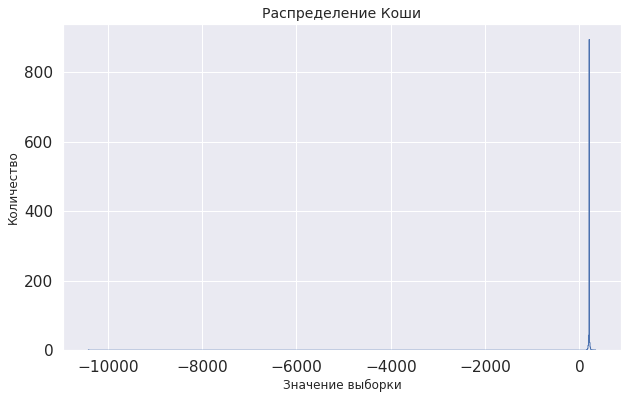

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Распределение Коши", fontsize=14)
plt.xlabel("Значение выборки", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.hist(x=cauchy_sample,bins=1000, histtype='step')
plt.show()

Удалим слишком маленькие значения, чтобы лучше рассмотреть график.

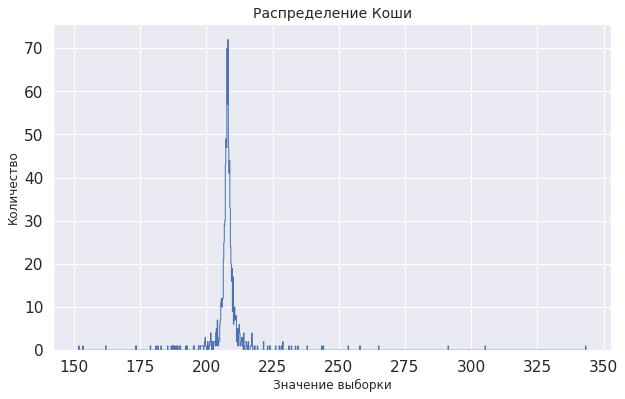

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Распределение Коши", fontsize=14)
plt.xlabel("Значение выборки", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.hist(x=cauchy_sample[cauchy_sample > -5000],bins=1000, histtype='step')
plt.show()

По теореме Гливенко-Кантелли, эмпирическая функция распределения сходится к реальной, и, при некоторых условиях, гистограмма сходится к плотности, если она существует. Тогда с учетом того, как выглядит плотность распределения Коши, можем предположить, что параметр равен 210.

3. Напишите функцию, которая находит оценку максимального правдоподобия, получив на вход выборку из распределения Коши находит максимум. Мы предполагаем, что Вы будете производить оценку по сетке --- для некоторого множества возможных параметров (отрезка с концами, которые Вам кажутся верными) постройте сетку с некоторым шагом (рекомендуется 0.01) и выберите лучший параметр на этой сетке.

Однако, если Вы хорошо поняли курс оптимизации, то напишите оптимизатор, который находит максимум сам. Задачу можно переформулировать, чтобы ответ не изменился, а оптимизация шла быстрее. За хорошо сформулированную оптимизационную задачу и реализацию мы добавим 5 бонусных баллов.

Найдем

$$\min_{\theta \in \mathbb{R}} (-\sum_{i = 1}^{n}ln(\frac{1}{\pi(1 + (X_i - \theta)^2)}))$$

Для этого воспользуемся классическим методом оптимизации - градиентным спуском.

In [ ]:
def f(X, theta):
    return -np.sum(np.log(1 / (np.pi * (1 + (X - theta)**2))))

def df(X, theta):
    return -np.sum(2 * (X - theta) / (np.pi * (1 + (X - theta)**2)))

In [ ]:
def gradient_descent(nabla_f, x_0, step=0.001, K=10**5):
    """
        Градиентный спуск минимизации функции f

        nabla_f - градиент функции f
        nabla_2_f - гессиан функции f
        x_0 - стартовая точка
        K - количество итераций
    """
    for i in range(K):
        x_0 = x_0 - step * nabla_f(x_0)
    return x_0

 Оцените параметр сдвига
методом максимального правдоподобия
* по первым 10 измерениям
* по первым 100 измерениям
* по всей выборке.


In [ ]:
gradient_descent(lambda theta: df(cauchy_sample[0:10], theta), 220)

208.5271943863931

In [ ]:
gradient_descent(lambda theta: df(cauchy_sample[0:100], theta), 220)

207.89950307164668

In [ ]:
gradient_descent(lambda theta: df(cauchy_sample, theta), 220)

207.9782648899353

4. Изучите функцию `sps.cauchy.fit`. Как она находит параметр? Сравните полученные результаты с результатом этой функции.

Она также находит параметр с помощью метода максимального правдоподобия.

In [ ]:
sps.cauchy.fit(cauchy_sample)

(207.97772827944334, 0.9451391657739334)

Значения, полученные с помощью градиентного спуска, совпадают с результатом sps.cauchy.fit до сотых.

Вспомните задачу 3 из домашнего задания 1, где были другие оценки распределения Коши. Сделайте вывод о том, какие оценки предпочтительнее.

## Задача 2

Имперские банки каждую ночь подсчитывают баланс ресурсов Ордалии по сравнению с вчерашней ночью. За день приходят как новые ресурсы, так и потребляются уже имеющиеся. Как и у любого другого банка, если обозначить $X^1$ – максимальное значение баланса за день, $X^2$ – значение баланса в полночь, то $X = X^1 - X^2$ имеет распределение Вейбулла с функцией распределения $F(x) = 1 - e^{-x^\gamma} (x > 0),$ где $\gamma > 0$ –
параметр масштаба. В файле Weibull.csv находятся соответствующие измерения.

Наша задача состоит в том, чтобы оценить параметр масштаба.

In [ ]:
weibull_sample = np.loadtxt("Weibull.csv")

1. Постройте гистограмму выборки. Не забудьте подобрать `xlim`, `ylim` и параметр `bins`, чтобы гистограмма была информативна.

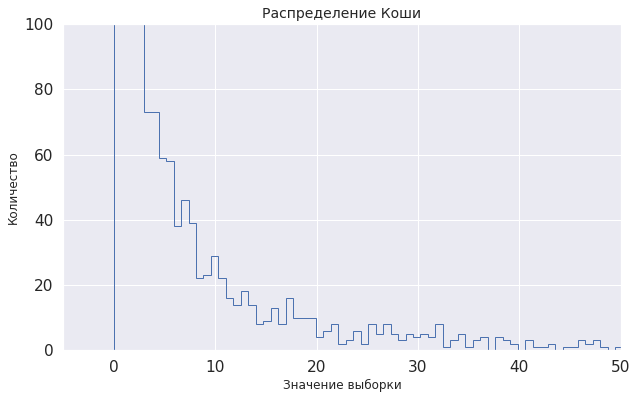

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Распределение Коши", fontsize=14)
plt.xlabel("Значение выборки", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.hist(x=weibull_sample, bins=500, histtype='step')
plt.xlim(-5, 50)
plt.ylim(0, 100)
plt.show()

Проведем небольшой предварительный анализ. Итак, если наши данные распределены согласно распределению Вейбулла, то справедливы следующие рассуждения:
$$
\begin{aligned} F(x) &=1-e^{-(x)^{\gamma}} \\-\ln (1-F(x)) &=x^{\gamma} \\ \underbrace{\ln (-\ln (1-F(x)))}_{y^{\prime}} &=\underbrace{\gamma \ln x}_{\text {kx }^{\prime}} \end{aligned}
$$
А значит и
$$
\underbrace{\ln (-\ln (1-\hat{F}(x)))}_{y^{\prime}} ≈\underbrace{\gamma \ln x}_{\text {kx }^{\prime}}
$$


Однако здесь мы сталкиваемся с проблемой: в нашей выборке есть нули. А логарифм нуля, как известно, не определен. Мы предлагаем вам придумать решение этой проблемы и обосновать его применимость. Ситуация, когда статистическая модель не описывает какие-то артефакты в данных (как, например, нули в этой задаче) для практики типична, и с ней приходится что-то делать.

Ответьте на два вопроса:
а. Могут ли нули появляться если честно семплировать из распределения Вейбулла?
б. Зная плотность распределения и то, что компьютерная точность неабсолютна, откуда нули всё-таки взялить, учитывая то, что авторы задания семплировали из распределения Вейбулла выборку?

Ответ:

В теории нули не должны появляться. Если посмотреть на плотность в нуле, то она будет равна 0. Также, если рассматривать самый популярный метод семплирования - генерацию величины из равномерного распределения, а после использования обратной функции - то так же получим, что величина 0 не может появиться.

Однако, в реальности могут возникать нули в сгенерированной выборке из-за ограничений компьютерной точности и округления значений. Например, если значения очень близки к нулю, то при округлении они могут быть округлены до нуля.

**Как будем избавляться от нулей?**

Попробуем несколько методов.

1. Так как нули получились из-за того, что количество знаков после запятой у float ограничена, то заменим нули маленьким значением.

2. Удалим нули.

3. Прибавим к выборке положительное число, оценим значение параметров. После вычтем из итогового значения.

In [ ]:
samples = [np.concatenate([weibull_sample[weibull_sample > 0],
                           weibull_sample[weibull_sample == 0] + 10**(-3)]),
           weibull_sample[weibull_sample > 0],
           weibull_sample + 10**(-3)]

2. Посчитайте эмпирическую функцию распределения и
$$y\prime = \ln (-\ln (1-\hat{F}(x))) \quad x' = ln x$$
 где $x$ – элементы исходной выборки.

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF  # can be useful, but not necessary
ecdfs_data = [ECDF(samples[i])(samples[i]) for i in range(len(samples))]

In [ ]:
points = [[np.log(ecdfs_data[i][ecdfs_data[i] != 1]), np.log(-np.log(1 - ecdfs_data[i][ecdfs_data[i] != 1]))]
          for i in range(len(ecdfs_data))]

**Постройте** график (`plt.scatter`) от (y', x') для Ваших способов борьбы с нулями разными цветами.
Не забудьте про `alpha=0.05` и легенду. Такой график называется `Weibull plot` и является аналогом `qqplot` для распределения Вейбулла.

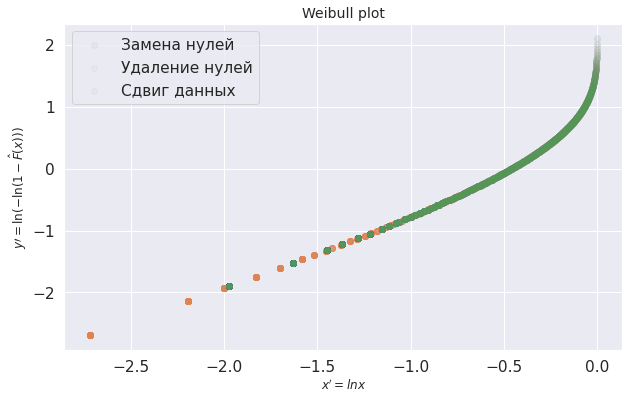

In [ ]:
titles = ["Замена нулей", "Удаление нулей", "Сдвиг данных"]

plt.figure(figsize=(10, 6))

for i in range(len(points)):
    plt.scatter(x=points[i][0], y=points[i][1], alpha=0.05, label=titles[i])

plt.title("Weibull plot", fontsize=14)
plt.xlabel("$x' = ln x$", fontsize=12)
plt.ylabel("$y\prime = \ln (-\ln (1-\hat{F}(x)))$", fontsize=12)
plt.legend()

Сделайте вывод. Какой способ вам кажется более правильным и почему?

**Вывод:**

3. Оцените параметр формы методом максимального правдоподобия
* по
первым 4 годам;
* по всей выборке.
Оценку произведите по сетке (в
логарифмической шкале) или оптимизатором. Известно, что $\log_{10}\gamma \in [-2, 2].$
Выберите шаг равным $10^{-3}.$

Решение:

Сравните результаты с `sps.weibull.fit(sample_2, fscale=1, floc=0)`

4. Постройте график $y = \gamma \cdot x$ для всех полученных $\gamma$ (`plt.plot`) и `scatter plot` из предыдущего пункта ($y\prime \ x\prime$) для того метода, который вам кажется более правильным. Хорошо ли линии соответствуют выборке? Как вы думаете, почему?

**Вывод**

## Задача 3

Хорошим методом получения аналитических оценок является метод моментов.

1. Сгенерируйте выборки $X_1, \ldots, X_N$ из $\mathit{N}(0, \theta)$, $U(0, \theta)$, $\Gamma(1, \theta)$ (**параметризация $k, \theta$**), $\theta = 3$ для всех распределений $(N = 1000).$ Посчитайте значения оценок (по выборке $X_1, \ldots X_n$) методом моментов. Промоделируйте полученные оценки для разных размеров выборки $n < N$ и изучите их скорости сходимости. На графике отразите истинный параметр. Можете построить отдельный график модуля/квадрата разности оценки и параметра (риск) для какой-то выборке и посмотреть, как быстро риск сходится к нулю.

Решение (вывод метода моментов для каждого случая):

Посчитаем значения методом моментов.

1. $N(0, \theta)$

$$EX_i^2 = \overline{X^2}$$
$$\theta - 0 = \overline{X^2}$$
$$\theta = \overline{X^2}$$

2. $U(0, \theta)$

$$EX_i = \overline{X}$$
$$\frac{\theta - 0}{2} = \overline{X}$$
$$\theta = 2\overline{X}$$

3. $Г(1, \theta)$

$$EX_i = \overline{X}$$
$$\theta = \overline{X}$$

Терерь смоделируем оценки и посмотрим на сходимость.

In [ ]:
theta = 3
size = 1000

sample_norm = sps.norm.rvs(size=size, scale=np.sqrt(theta)) # scale^2 = theta
sample_uniform = sps.uniform.rvs(size=size, scale=theta)
sample_gamma = sps.gamma.rvs(a=1, size=size, scale=theta)

In [ ]:
theta_norm = np.cumsum(sample_norm**2) / np.arange(1, size + 1)
theta_uniform = 2 * np.cumsum(sample_uniform) / np.arange(1, size + 1)
theta_gamma = np.cumsum(sample_gamma) / np.arange(1, size + 1)

Полученные значения:

In [ ]:
print(f"Нормальное распределение - {theta_norm[-1]}")
print(f"Равномерное распределение - {theta_uniform[-1]}")
print(f"Гамма-распределение - {theta_gamma[-1]}")

Нормальное распределение - 3.191575220729433
Равномерное распределение - 2.9481595471893103
Гамма-распределение - 3.078022133893563


Построим графики.

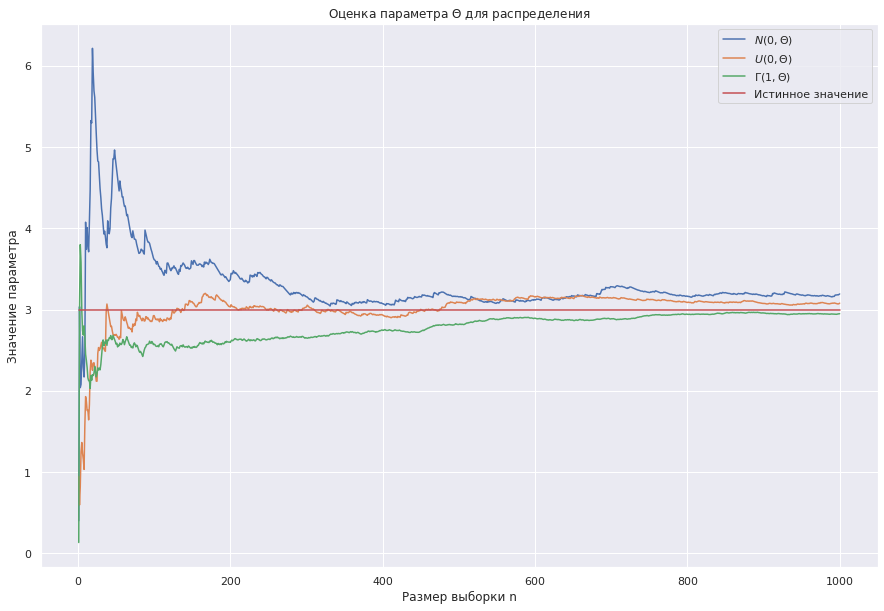

In [ ]:
with sns.plotting_context("notebook"), sns.axes_style('darkgrid'):
    plt.figure(figsize=(15,10))

    plt.plot(np.arange(1, size + 1), theta_norm, label="$\mathit{N}(0, \Theta)$")
    plt.plot(np.arange(1, size + 1), theta_gamma, label="$U(0, \Theta)$")
    plt.plot(np.arange(1, size + 1), theta_uniform, label="$\Gamma(1, \Theta)$")
    plt.plot(np.arange(1, size + 1), [theta]*size, label="Истинное значение")

    plt.title("Оценка параметра $\Theta$ для распределения", fontsize=12)
    plt.xlabel("Размер выборки n", fontsize=12)
    plt.ylabel("Значение параметра", fontsize=12)

    plt.legend()
    plt.show()

Посмотрим также на квадратичные функции риска.

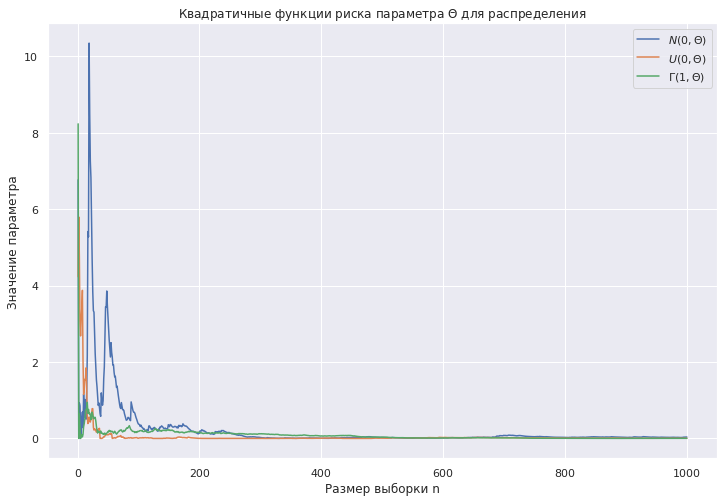

In [ ]:
with sns.plotting_context("notebook"), sns.axes_style('darkgrid'):
    plt.figure(figsize=(12,8))

    plt.plot(np.arange(1, size + 1), (theta_norm - theta)**2, label="$\mathit{N}(0, \Theta)$")
    plt.plot(np.arange(1, size + 1), (theta_gamma - theta)**2, label="$U(0, \Theta)$")
    plt.plot(np.arange(1, size + 1), (theta_uniform - theta)**2, label="$\Gamma(1, \Theta)$")

    plt.title("Квадратичные функции риска параметра $\Theta$ для распределения", fontsize=12)
    plt.xlabel("Размер выборки n", fontsize=12)
    plt.ylabel("Значение параметра", fontsize=12)

    plt.legend()
    plt.show()

Ограничимся 200 наблюдениями.

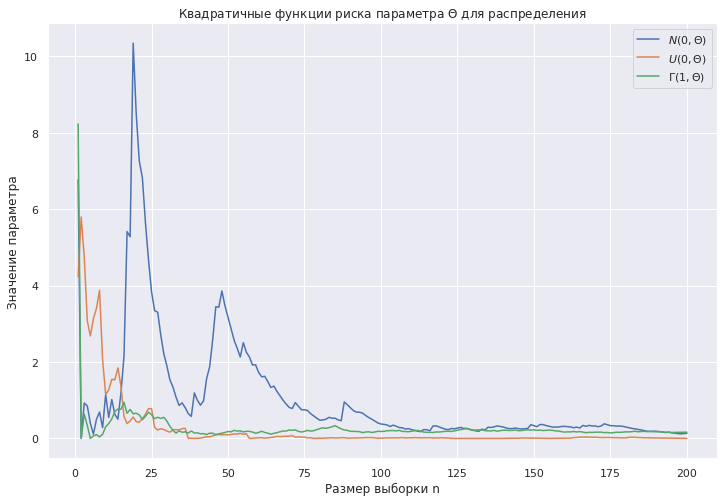

In [ ]:
with sns.plotting_context("notebook"), sns.axes_style('darkgrid'):
    plt.figure(figsize=(12,8))

    plt.plot(np.arange(1, 201), ((theta_norm - theta)**2)[:200], label="$\mathit{N}(0, \Theta)$")
    plt.plot(np.arange(1, 201), ((theta_gamma - theta)**2)[:200], label="$U(0, \Theta)$")
    plt.plot(np.arange(1, 201), ((theta_uniform - theta)**2)[:200], label="$\Gamma(1, \Theta)$")

    plt.title("Квадратичные функции риска параметра $\Theta$ для распределения", fontsize=12)
    plt.xlabel("Размер выборки n", fontsize=12)
    plt.ylabel("Значение параметра", fontsize=12)

    plt.legend()
    plt.show()

2. Есть два замечательных распределения, которые игнорировать никак нельзя. Первое --- $Pareto(k)$ с плотностью $p(x) = kx^{-k-1}$ ($k$ произвольное), $Cauchy(0, \theta)$  с плотностью $p(x) = \frac{\theta}{x^2 + \theta^2}$. Запишите оценки методом моментов для них и проверьте их на состоятельность на практике (моделированием). Подсказка: внимательно изучите, чему равны моменты каждого из распределений и при каких условиях. Можно ли гарантировать состоятельность полученных оценок каким-то теоретическими фактами?

Решение (аналитический вывод оценок):

Данные распределния особены тем, что для них в стандартном виде не применим метод моментом. Нам необходимо применять данный метод к каким-то функциям.

П1. $\zeta$ ~ $Pareto(k)$

Тогда посмотрим на $ln \zeta$.

$$F_{ln\zeta}(x) = P(ln\zeta \leq x) = P(\zeta \leq e^x) = F_{\zeta}(e^x)$$

$$F_{\zeta}(x) = (1 - \frac{1}{x^k}) I(x \geq 1)$$
$$F_{ln{\zeta}}(x) = (1 - e^{-kx}) I(x \geq 0)$$

А это функция распределения экспоненциального распределения, для которого можно применить метод моментов.

$$E{ln(X)} = \overline{ln(X)}$$
$$\frac{1}{k} = \overline{ln(X)}$$
$$k = \frac{1}{\overline{ln(X)}}$$

2. $Cauchy(0, \theta)$

Матожидание распределения Коши = $\infty $, поэтому рассмотрим функцию, которая будет меньшим порядком. Например, быстро можно посчитать для интеграл $f(x) = \frac{1}{1 + x^2}$:

$$\int_{\mathbb{R}}\frac{1}{1+x^2}\frac{\theta}{\pi(\theta^2 + x^2)}dx = \int_{\mathbb{R}}\frac{\theta}{\pi(\theta^2 - 1)} \frac{\theta^2 + x^2 - x^2 - 1}{(\theta^2 + x^2)(1 + x^2))} dx =  \frac{\theta}{\pi(\theta^2 - 1)} \int_{\mathbb{R}}(\frac{1}{1 + x^2} - \frac{1}{\theta^2 + x^2})dx =  \frac{\theta}{\pi(\theta^2 - 1)} (arctg(x) - \frac{1}{\theta}arctg(\frac{x}{\theta})) |_{-\infty}^{\infty} =  \frac{\theta}{\pi(\theta^2 - 1)}(\frac{\pi}{2} + \frac{\pi}{2} - \frac{1}{\theta}(\frac{2\pi}{2})) = \frac{1}{1 + \theta}$$

$$E{\frac{1}{1 + X^2}} = \overline{\frac{1}{1 + X^2}}$$
$$\frac{1}{1 + \theta} = \overline{\frac{1}{1 + X^2}}$$
$$\theta = \frac{1}{\overline{\frac{1}{1 + X^2}}} - 1$$

Моделирование:

In [ ]:
# моделируем выборку
sample_cauchy = sps.cauchy.rvs(size=size, scale=theta)
sample_pareto = sps.pareto.rvs(size=size, b=theta)

# получаем оценки
theta_pareto = 1 / (np.cumsum(np.log(sample_pareto)) / np.arange(1, size + 1))
theta_cauchy = 1 / ((np.cumsum(1 / (1 + sample_cauchy**2))) / np.arange(1, size + 1)) - 1

Получили значения:


In [ ]:
print(f"Распределение Парето - {theta_pareto[-1]}")
print(f"Распределение Коши - {theta_cauchy[-1]}")

Распределение Парето - 2.987213829981918
Распределение Коши - 2.9035060419951093


Посторим графики.

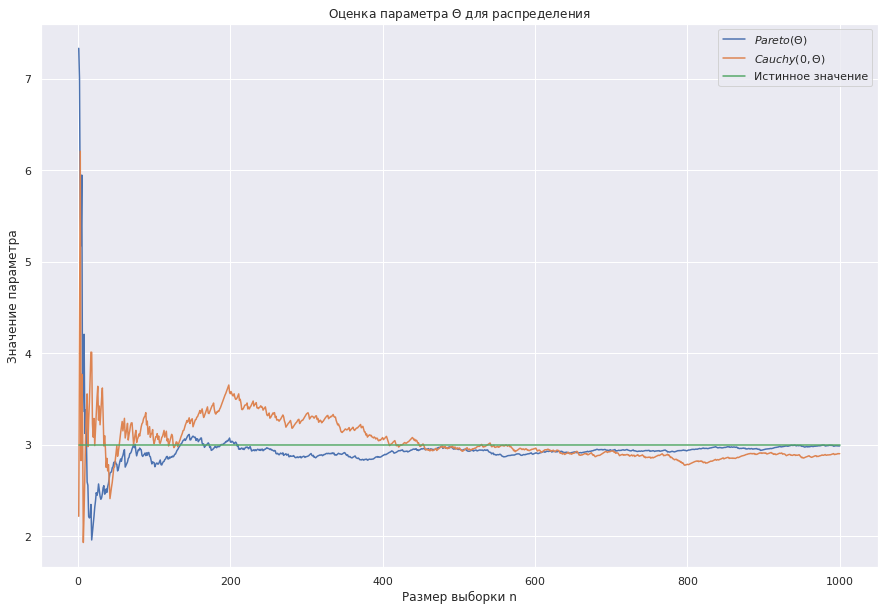

In [ ]:
with sns.plotting_context("notebook"), sns.axes_style('darkgrid'):
    plt.figure(figsize=(15,10))

    plt.plot(np.arange(1, size + 1), theta_pareto, label="$Pareto(\Theta)$")
    plt.plot(np.arange(1, size + 1), theta_cauchy, label="$Cauchy(0, \Theta)$")
    plt.plot(np.arange(1, size + 1), [theta]*size, label="Истинное значение")

    plt.title("Оценка параметра $\Theta$ для распределения", fontsize=12)
    plt.xlabel("Размер выборки n", fontsize=12)
    plt.ylabel("Значение параметра", fontsize=12)

    plt.legend()
    plt.show()

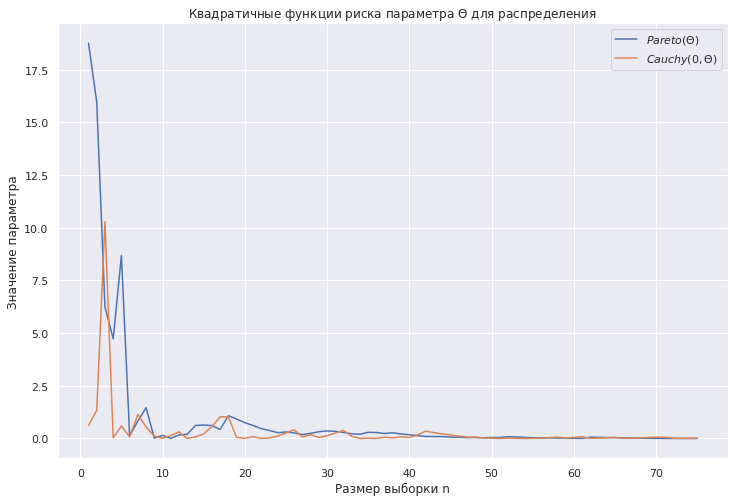

In [ ]:
with sns.plotting_context("notebook"), sns.axes_style('darkgrid'):
    plt.figure(figsize=(12,8))

    plt.plot(np.arange(1, 76), ((theta_pareto - theta)**2)[:75], label="$Pareto(\Theta)$")
    plt.plot(np.arange(1, 76), ((theta_cauchy - theta)**2)[:75], label="$Cauchy(0, \Theta)$")

    plt.title("Квадратичные функции риска параметра $\Theta$ для распределения", fontsize=12)
    plt.xlabel("Размер выборки n", fontsize=12)
    plt.ylabel("Значение параметра", fontsize=12)

    plt.legend()
    plt.show()

**Вывод:**

**Следующие две задачи посвящены тому, как получать более информативные оценки, чем точечные. Нам приходится обращаться к ним, так как свойства точечных оценок являются предельными, и мы мало что знаем о том, насколько конкретное значение оценки близко к истинному значению параметра. В условиях кровавой войны информация должна быть максимальной.**

### Задача 4. Бутстреп

Для реальных данных часто сложно подобрать распределение и нужную параметризацию относительно $\theta$. Кроме того на практике сложно посчитать дисперсию оценки (для этого хотя бы нужно знать распределение, из которого пришла выборка) и какой-то отрезок, в который параметр попадёт с высокой вероятностью (такой отрезок называется **доверительным интервалом**_. На помощь в таких случаях приходит **бутстреп**.

Идея очень простая. Вспомним, как работает **метод подстановки** для получения оценок. В нём мы выражаем параметр при помощи распределения (как среднее или медиана, например), потом меняем распределение на эмпирическое и выражаем параметр уже через него. Бутстреп это подмена истинного распределения на эмпирическое.



1. Для каждого распределения из задачи 3 сгенерируйте выборку размера $N = 1000$. Далее замените Ваше распределение на равномерное распределение по построенной выборке (по теореме Гливенко-Кантелли эти распределения достаточно близки), и из эмпирического (равномерного) распределения постройте 100 выборок. Опишите, как Вы будете это делать. Указание: из истинного распределения (нормального и т.д.) новые данные генерировать **нельзя**. Бутстреп это способ получения псевдо-новых данных из уже имеющихся.

Ответ:

In [ ]:
theta = 3
size = 1000
number_samples = 100

sample_norm = sps.norm.rvs(size=size, scale=np.sqrt(theta)) # scale^2 = theta
sample_uniform = sps.uniform.rvs(size=size, scale=theta)
sample_gamma = sps.gamma.rvs(a=1, size=size, scale=theta)
sample_cauchy = sps.cauchy.rvs(size=size, scale=theta)
sample_pareto = sps.pareto.rvs(size=size, b=theta)

Будем создавать новые выборки как выборки с повторениями того же размера, что и исходные данные.

In [ ]:
def create_new_sample(sample, number_samples):
    return np.random.choice(sample, replace=True, size=(number_samples, sample.shape[0]))

bsample_norm = create_new_sample(sample_norm, number_samples)
bsample_uniform = create_new_sample(sample_uniform, number_samples)
bsample_gamma = create_new_sample(sample_gamma, number_samples)
bsample_cauchy = create_new_sample(sample_cauchy, number_samples)
bsample_pareto = create_new_sample(sample_pareto, number_samples)

2. Для каждой псевдо-выборки из предыдущего пункта постройте оценку методом моментов из задачи 3 и получится выборка оценок (как в домашке 1). По ней посчитайте эмпирическую (выборочную) дисперсию оценок и сделайте вывод о том, как связано значение дисперсии оценки (теоретической и бутстрепной) с точностью и скоростью сходимости оценки к параметру.

Посчитаем оценки

In [ ]:
theta_norm = np.sum(bsample_norm **2, axis=1) / size
theta_uniform = 2 * np.sum(bsample_uniform, axis=1) / size
theta_gamma = np.sum(bsample_gamma, axis=1) / size
theta_pareto = 1 / (np.sum(np.log(bsample_pareto), axis=1) / size)
theta_cauchy = 1 / (np.sum(1 / (1 + bsample_cauchy**2), axis=1) / size) - 1

Найдем выборочную дисперсию

In [ ]:
def Var(X):
    return np.mean(X**2) - np.mean(X)**2

var_norm = Var(theta_norm)
var_uniform = Var(theta_uniform)
var_gamma = Var(theta_gamma)
var_pareto = Var(theta_pareto)
var_cauchy = Var(theta_cauchy)

In [ ]:
print(var_norm, var_uniform, var_gamma, var_pareto, var_cauchy)

0.013874724982843034 0.0025590317510300054 0.00839295023469333 0.009657252074047662 0.017610943700942627


3. Бутстрепным доверительным интервалом порядка $\alpha$ называется отрезок $[\theta_{\frac{\alpha}{2}}, \theta_{\frac{1 - \alpha}{2}}]$, где $\theta_{\alpha}$ это выборочный $\alpha$-квантиль из распределения оценок, построенного в задаче методом бутстрепа. Опишите, как такой выборочный квантиль связан с истинным квантилем распределения оценок и каким свойством обладал бы построенный отрезок, если бы мы его строили не эмпирически, а точно (с настоящими квантилями). Постройте доверительный интервал численно для разных значений параметра и изучите, часто ли параметр в него попадает.

- Точный доверительный интервал содержит нужное значение с нужным уровнем доверия
- Бутстрепный выборочный квантиль является приближением, который зависит от выборки
- Он может быть не точным в случае оценок максимального или минимального значения, так как вероятнее всего будет смещение в меньшую/большую сторону. Ведь мы не можем получить значения больше, чем в выборке.

In [ ]:
alpha = 0.05

left = np.quantile(theta_norm, alpha/2)
right = np.quantile(theta_norm, (1 - alpha)/2)

left, right

(2.838393861940272, 3.0629068596798965)

**Вывод:**

Если истинный минимум или максимум распределения лежит за пределами ваших данных, то никакая повторная выборка ваших данных с помощью bootstrap не даст оценок, приближенных к истинному минимуму или максимуму. Этот ответ дает более формальное описание того, насколько велика эта проблема, в случае начальной оценки статистики максимального (или минимального) порядка из выборок равномерного распределения.

Также возникают проблемы при попытке оценить экстремальные квантили, такие как 1% или 99%, с помощью bootstrap. Этот ответ дает хорошее объяснение. Распределение экстремальных значений среди выборок начальной загрузки в таком случае больше связано с причудами повторной выборки, чем с базовым распределением интересующей совокупности.

### Задача 5. Байес.

**Эта задача стоит 20 баллов**

Байесовское оценивание даёт ультиматимативный способ построения оценок без какой-либо потери в информации. Теперь мы оцениваем параметры распределения не точками и не отрезками, а распределениями!

1. Будем смотреть на параметрическое семейство распределений как на условное распределение: $P_{\theta} = P(X | \theta)$. В байесовском подходе подразумевается, что параметр $\theta$ сам приходит из некоторого **априорного** распределения (которое статист либо предпологает сам, либо предпологает исходя из внешних знаний об области).

Вспомним теорему Байеса: $p(\theta | X) = \frac{p(X | \theta) p(\theta)}{p(X)}$, где знаменатель $p(x)$ получается как интеграл по $\theta$ от числителя. В зависимости от того, можем ли мы взять этот интеграл, выбирается тип байесовской оценки. $p(X | \theta)$ мы знаем, это хорошо нам знакомое правдоподобие, $p(\theta)$ называется априорным распределением (prior) параметра, мы его выбираем сами исходя из наших предпочтений, $p(X)$ от параметра не зависит и называется обоснованностью (evidence), и показывает, насколько правдоподобна выборка в терминах выбранного семейства распределений.

Для первого пункта задачи выберите некоторое нетривиальное значение параметра для двух распределений: $Bern(p)$, $Exp(\lambda)$ и сгенерируйте по одной выборке размера $N = 1000$.

2. "Байес для бедных" (Poor man's bayes)

Пусть интеграл в знаменателе мы считать не умеем и мы готовы с этим смириться. Что в таком случае делать? Можно искать моду (максимум) апостериорной плотности $P(\theta | X)$, где $X$ --- выборка, и рассматривать оценку $\theta$ как точку максимума.

Подберите три различных априорных распределения на параметр и найдите максимум апостериорной плотности.
Преобразуйте задачу максимизации и найдите максимум по сетке или оптимизатором.

Сделайте вывод о том, как влияет априорная информация о параметре на оценку? Вспомните лекции из курса машинного обучения. На какой объект похоже априорное распределение? Как его следует выбирать. Как связаны максимум апостериорной плотности и оценка максимального правоподобия?

3. Байес для богатых (обычный байес).

Отказываться считать интеграл нельзя, за это полагается смертная казнь.

Проверьте, что для распределения Бернулли можно взять априорное распределение в виде бета распределения $Beta(1, 1)$ и тогда апостериорная плотность будет также принадлежать семейству бета распределений. Какие параметры будут у апостериорной плотности?

Решение:

Рассуждение выше означает, что интеграл можно не считать, так как он будет известен исходя из того, что апостериорное распределение будет принадлежать семейству бета распределений. А найденные параметры бета распределения и будут хорошим приближением параметра. По выборке из распределения Бернулли посчитайте параметры апостериорной плотности и изобразите её плотность на графике.

Что Вы бы брали точечной оценкой параметра исходя из апостериорного распределения? Почему?

Как апостериорное распределение изменяется при разных параметрах априорного бета-распределения? Как выбирать эти параметры на практике? Какой смысл они несут? Снова вспомните лекции из курса машинного обучения.

Такие пары распределений называются **сопряжёнными**. Для сопряжённых распределений верно, что после применения теоремы Байеса апостериорная плотность лежит в том же параметрическом семействе, что и априорная.

Для экспоненциального распределения сопряжённым является Гамма-распределение.

Проделайте для экспоненциального распределения ту же работу, что и для Бернулли.

Сделайте вывод о байесовском оценивании: